# Getting some top-level data from the DigitalNZ API

This notebook pokes around at the top-level of DigitalNZ, mainly using facets.

See the [API documentation](https://digitalnz.org/developers/api-docs-v3) for more detailed information.

In [143]:
import requests
import pandas as pd
import altair as alt
from IPython.display import display, HTML

alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

[Get yourself an API key](https://digitalnz.org/developers/getting-started) and paste it between the quotes below.

In [183]:
api_key = ''
print('Your API key is: {}'.format(api_key))

Your API key is: 


In [174]:
# Base url for queries
api_search_url = 'http://api.digitalnz.org/v3/records.json'

# Set up the query params (we'll change these later)
# Let's start with an empty text query to look at everything
params = {
    'api_key': api_key,
    'text': ''
}

In [18]:
def get_data():
    '''
    Retrieve an API query and extract the JSON payload.
    '''
    response = requests.get(api_search_url, params=params)
    return response.json()

## Hello world!

In [23]:
# How many items are there?
data = get_data()
print(' There are {:,} items'.format(data['search']['result_count']))

 There are 31,086,352 items


## Items by century

In [24]:
params['facets'] = 'century'
data = get_data()

In [54]:
centuries = data['search']['facets']['century']
centuries_df = pd.Series(centuries).to_frame().reset_index()
centuries_df.columns = ['century', 'count']
centuries_df

,century,count
0,1900,16913154
1,1800,11331117
2,2000,1950527
3,1700,3541
4,1600,1550
5,1500,465
6,1300,198
7,8000,166
8,1400,163
9,1200,95


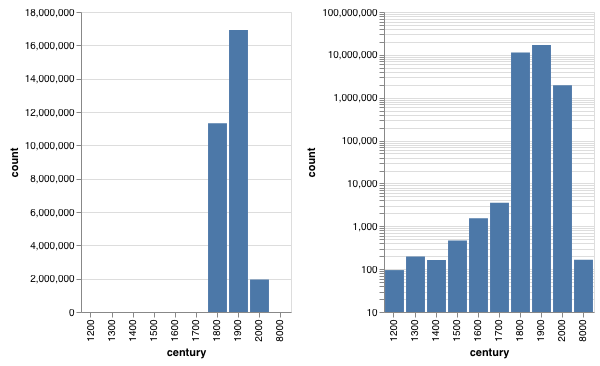

In [69]:
c1 = alt.Chart(centuries_df).mark_bar().encode(
    x = 'century:O',
    y = 'count:Q',
    tooltip = alt.Tooltip('count', format=',')
)
c2 = alt.Chart(centuries_df).mark_bar().encode(
    x = 'century:O',
    y = alt.Y('count:Q', 
          scale=alt.Scale(type='log')),
    tooltip = alt.Tooltip('count', format=',')
)
c1 | c2

## Items by decade

In [86]:
params['facets'] = 'decade'
params['facets_per_page'] = 25
data = get_data()

In [87]:
decades = data['search']['facets']['decade']
decades_df = pd.Series(decades).to_frame().reset_index()
decades_df.columns = ['decade', 'count']
decades_df.head()

,decade,count
0,1900,6505364
1,1910,6236371
2,1890,4802465
3,1880,3716245
4,1870,1868130


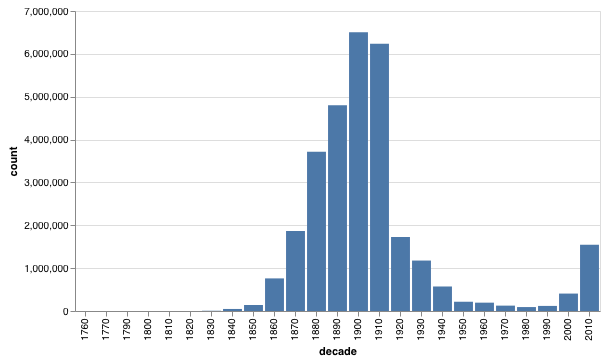

In [105]:
alt.Chart(decades_df).mark_bar().encode(
    x = 'decade:O',
    y = 'count:Q',
    tooltip = alt.Tooltip('count', format=',')
)

## Top 25 collections

In [130]:
params['facets'] = 'display_collection'
params['facets_per_page'] = 26
data = get_data()

In [131]:
# Note that the facet is called 'primary_collection' in the results!
collections = data['search']['facets']['primary_collection']
collections_df = pd.Series(collections).to_frame().reset_index()
collections_df.columns = ['collection', 'count']
collections_df.head()

,collection,count
0,Papers Past,26577755
1,Radio New Zealand,624036
2,NatureWatch NZ,405193
3,TAPUHI,306416
4,New Zealand Electronic Text Collection,222293


Papers Past is so much bigger than anything else, let's exclude it from the chart.

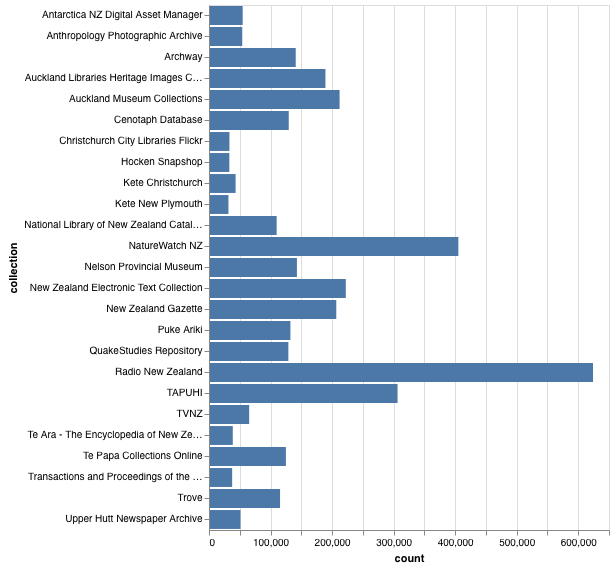

In [132]:
alt.Chart(collections_df[1:]).mark_bar().encode(
    x=alt.X('count:Q'),
    y=alt.Y('collection:N'),
    tooltip = alt.Tooltip('count', format=',')
)

## Create a dataset of all collections

In [139]:
more = True
all_collections = {}
params['facets'] = 'display_collection'
params['facets_per_page'] = 100
params['facets_page'] = 1
while more:
    data = get_data()
    facets = data['search']['facets']['primary_collection']
    if facets:
        all_collections.update(facets)
        params['facets_page'] += 1
    else:
        more = False

In [140]:
all_collections_df = pd.Series(all_collections).to_frame().reset_index()
all_collections_df.columns = ['collection', 'count']
all_collections_df.head()

,collection,count
0,Papers Past,26577755
1,Radio New Zealand,624036
2,NatureWatch NZ,405193
3,TAPUHI,306416
4,New Zealand Electronic Text Collection,222293


In [144]:
all_collections_df.to_csv('digitalnz_collections.csv', index=False)
display(HTML('<a href="digitalnz_collections.csv">Download CSV file</a>'))

## Top 25 newspapers in Papers Past

In [176]:
params['facets'] = 'collection'
params['and[display_collection][]'] = 'Papers Past'
params['facets_per_page'] = 26
params['facets_page'] = 1
data = get_data()

In [177]:
newspapers = data['search']['facets']['collection']
newspapers_df = pd.Series(newspapers).to_frame().reset_index()
newspapers_df.columns = ['newspaper', 'count']
newspapers_df.head()

,newspaper,count
0,Papers Past,26577755
1,Evening Post,3772941
2,Otago Daily Times,1583125
3,Wanganui Chronicle,1163217
4,Hawera & Normanby Star,1075326


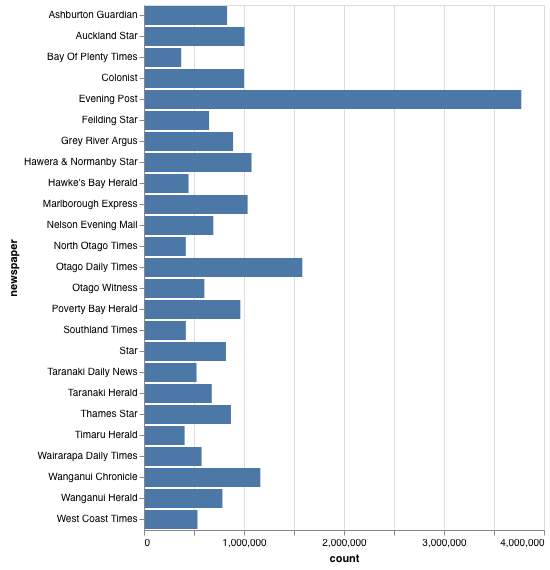

In [178]:
alt.Chart(newspapers_df[1:]).mark_bar().encode(
    x=alt.X('count:Q'),
    y=alt.Y('newspaper:N'),
    tooltip = alt.Tooltip('count', format=',')
)

## All newspapers in Papers Past

In [179]:
more = True
all_newspapers = {}
params['facets'] = 'collection'
params['and[display_collection][]'] = 'Papers Past'
params['facets_per_page'] = 100
params['facets_page'] = 1
while more:
    data = get_data()
    facets = data['search']['facets']['collection']
    if facets:
        all_newspapers.update(facets)
        params['facets_page'] += 1
    else:
        more = False

In [180]:
all_newspapers_df = pd.Series(all_newspapers).to_frame().reset_index()
all_newspapers_df.columns = ['newspaper', 'count']
all_newspapers_df.head()

,newspaper,count
0,Papers Past,26577755
1,Evening Post,3772941
2,Otago Daily Times,1583125
3,Wanganui Chronicle,1163217
4,Hawera & Normanby Star,1075326


In [182]:
all_newspapers_df[1:].to_csv('paperspast_newspapers.csv', index=False)
display(HTML('<a href="paperspast_newspapers.csv">Download CSV file</a>'))